In [2]:
import altair as alt
import pandas as pd
import numpy as np

In [32]:
data = pd.read_csv('Refinery_Site_Stats.csv').drop('ID', axis=1).drop([0])
data.columns = data.columns.str.replace(' ', '_')
data['run_date'] = pd.to_datetime(data['run_date']).dt.normalize()
data.head()

,datasets_shared,datasets_uploaded,groups_created,run_date,total_user_logins,total_visualization_launches,total_workflow_launches,users_created,unique_user_logins
1,0,2,1,2018-05-30,11,2,0,24,6
2,0,0,1,2018-05-31,6,1,2,13,5
3,0,0,0,2018-06-01,1,3,0,18,1
4,0,0,0,2018-06-02,0,0,0,17,0
5,0,0,0,2018-06-03,0,0,0,7,0


In [27]:
brush = alt.selection_interval(encodings=['x'])
nearest = alt.selection_single(nearest=True, on='mouseover', encodings=['x'], empty='none')

base = alt.Chart(data).encode(
    alt.X('run_date:T', title=None)
)

selectors = base.mark_point().encode(
    opacity=alt.value(0),
).properties(
    selection=nearest
).transform_filter(
    brush
)

rules = base.mark_rule(color='gray').transform_filter(
    nearest
).transform_filter(
    brush
)

In [28]:
def create_panel(view, w, h):
    
    line = base.mark_line(interpolate='step-before').encode(
        alt.Y(view + ':Q', title=None),
    ).transform_filter(
        brush
    )

    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, view + ':Q', alt.value(' '))
    ) 

    panel = alt.layer(line, selectors, points, rules, text, width=w, height=h, title=view.replace('_', ' '))
    
    return panel

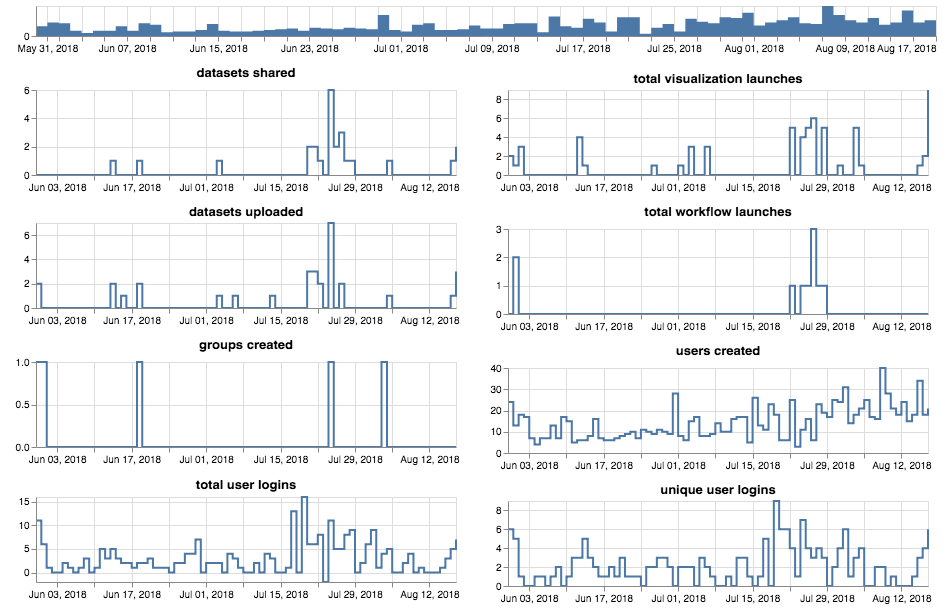

In [29]:
views = [col for col in data.columns.tolist() if col != 'run_date']

panels = [create_panel(view, 420, 85) for view in views]

timeline = base.mark_area(interpolate='step-after').encode(
    alt.Y('users_created:Q', title=None)
).properties(
    width=900,
    height=30,
    selection=brush
)

chart = timeline & (alt.vconcat(*panels[:4]) | alt.vconcat(*panels[4:]))

chart

In [33]:
# save Vega-Lite schema
chart.save('chart.json')